<img src="https://i.imgur.com/aEnbuWy.jpg" width="800">

**Melanoma** is a serious form of skin cancer that begins in cells known as melanocytes. While it is less common than **Basal cell carcinoma (BCC)** and **Squamous cell carcinoma (SCC)**, melanoma is more dangerous because of its ability to spread to other organs more rapidly if it is not treated at an early stage. The early diagnosis of melanoma can improve the prognosis and chance of survival significantly, as it can promote timely clinical treatment to patients. Further accurate classification of benign tumors can prevent patients from undergoing unnecessary treatments. Thus, the correct diagnosis of melanoma and classification of patients into malignant or benign groups is the subject of much research.

**The goal** of this project is to classify whether the melanoma is **benign** or **malignant** 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import tensorflow as tf
from tqdm.notebook import tqdm
from kaggle_datasets import KaggleDatasets
from collections import Counter
from tensorflow.keras import layers as L
import sklearn

/kaggle/input/siim-isic-melanoma-classification/test.csv
/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv
/kaggle/input/siim-isic-melanoma-classification/train.csv
/kaggle/input/siim-isic-melanoma-classification/train/ISIC_6977092.dcm
/kaggle/input/siim-isic-melanoma-classification/train/ISIC_2673608.dcm
/kaggle/input/siim-isic-melanoma-classification/train/ISIC_6264932.dcm
/kaggle/input/siim-isic-melanoma-classification/train/ISIC_3175723.dcm
/kaggle/input/siim-isic-melanoma-classification/train/ISIC_3951907.dcm
/kaggle/input/siim-isic-melanoma-classification/train/ISIC_7589300.dcm
/kaggle/input/siim-isic-melanoma-classification/train/ISIC_8092503.dcm
/kaggle/input/siim-isic-melanoma-classification/train/ISIC_1030453.dcm
/kaggle/input/siim-isic-melanoma-classification/train/ISIC_4434221.dcm
/kaggle/input/siim-isic-melanoma-classification/train/ISIC_2739702.dcm
/kaggle/input/siim-isic-melanoma-classification/train/ISIC_7180438.dcm
/kaggle/input/siim-isic-melanoma-c

In [2]:
!pip install -q efficientnet

# EDA and Visualization

In [3]:
train = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/train.csv')
test = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/test.csv')
sample_submission = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv')

In [4]:
train.head()

image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   

  diagnosis benign_malignant  target  
0   unknown           benign       0  
1   unknown           benign       0  
2     nevus           benign       0  
3   unknown           benign       0  
4   unknown           benign       0

In [5]:
test.head()

image_name  patient_id     sex  age_approx anatom_site_general_challenge
0  ISIC_0052060  IP_3579794    male        70.0                           NaN
1  ISIC_0052349  IP_7782715    male        40.0               lower extremity
2  ISIC_0058510  IP_7960270  female        55.0                         torso
3  ISIC_0073313  IP_6375035  female        50.0                         torso
4  ISIC_0073502  IP_0589375  female        45.0               lower extremity

Visualization of data is an imperative aspect of data science. It helps to understand data and also to explain it to another person. Python has several interesting visualization libraries such as Matplotlib, Seaborn etc

Benign: 98.24%
Malignant: 1.76%


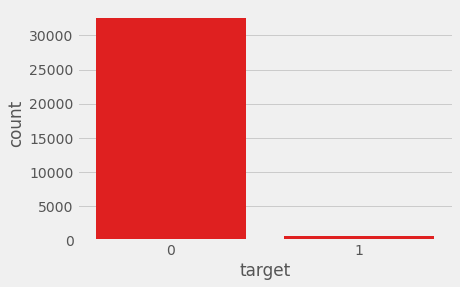

In [6]:
#Plotting overall number of benign and malignant tumors
plt.style.use('fivethirtyeight')
sns.countplot(x='target', data=train, color='red')
print('Benign: {}%'.format(round(train.target.value_counts()[0]/len(train)*100.0,2)))
print('Malignant: {}%'.format(round(train.target.value_counts()[1]/len(train)*100.0,2)))

In our example, we have images with 98.24% belonging to the "yes" class and 1.76% belonging to the "no" class. We encounter a problem known as data imbalance, where the number of observations per class is not equally distributed. There are many instances of data imbalance in medicine, since usually there would be very less number of unhealthy patients than the number of healthy patients in most cases 

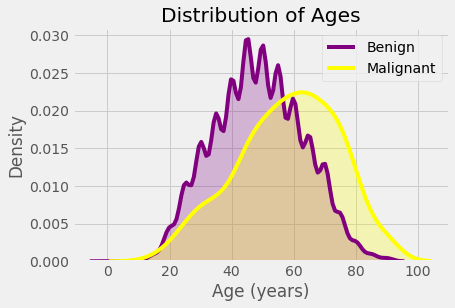

In [7]:
#Plotting distribution of ages by benign vs malignant tumors
sns.kdeplot(train.loc[train['target'] == 0, 'age_approx'], label = 'Benign',shade=True, color='purple')
sns.kdeplot(train.loc[train['target'] == 1, 'age_approx'], label = 'Malignant',shade=True, color='yellow')
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

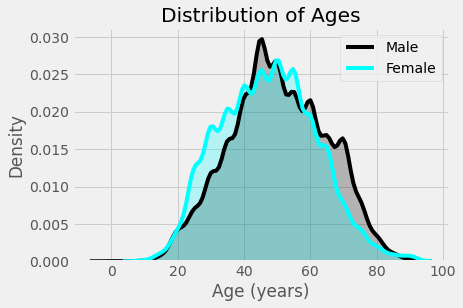

In [8]:
#Plotting distribution of ages by male vs female persons
sns.kdeplot(train.loc[train['sex'] == 'male', 'age_approx'], label = 'Male',shade=True, color='black')
sns.kdeplot(train.loc[train['sex'] == 'female', 'age_approx'], label = 'Female',shade=True, color='cyan')
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

Text(0.5, 1.0, 'Affected Body Parts')

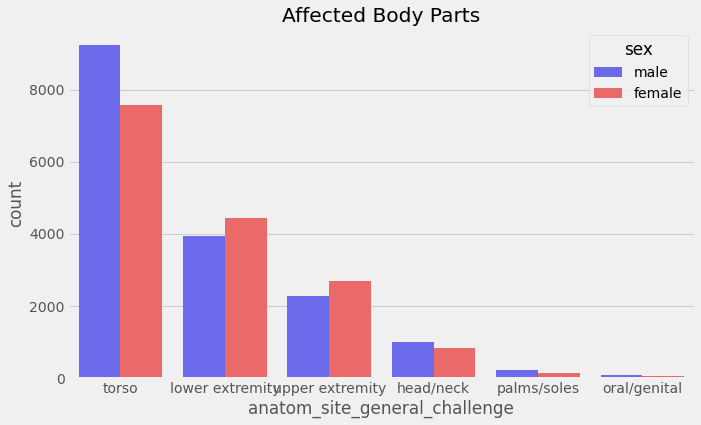

In [9]:
#Plotting number of tumors by affected body parts
fig= plt.figure(figsize=(10,6))
ax = sns.countplot(x="anatom_site_general_challenge", data=train, hue='sex', palette='seismic',
                  order=train['anatom_site_general_challenge'].value_counts().index)
plt.title("Affected Body Parts")

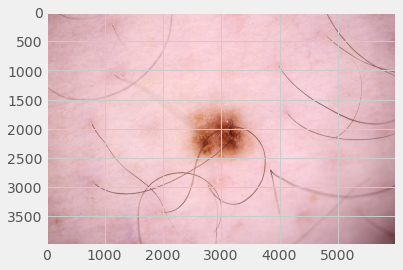

In [10]:
#Plotting a random image
img = plt.imread('/kaggle/input/siim-isic-melanoma-classification/jpeg/train/ISIC_5766923.jpg')
plt.imshow(img)

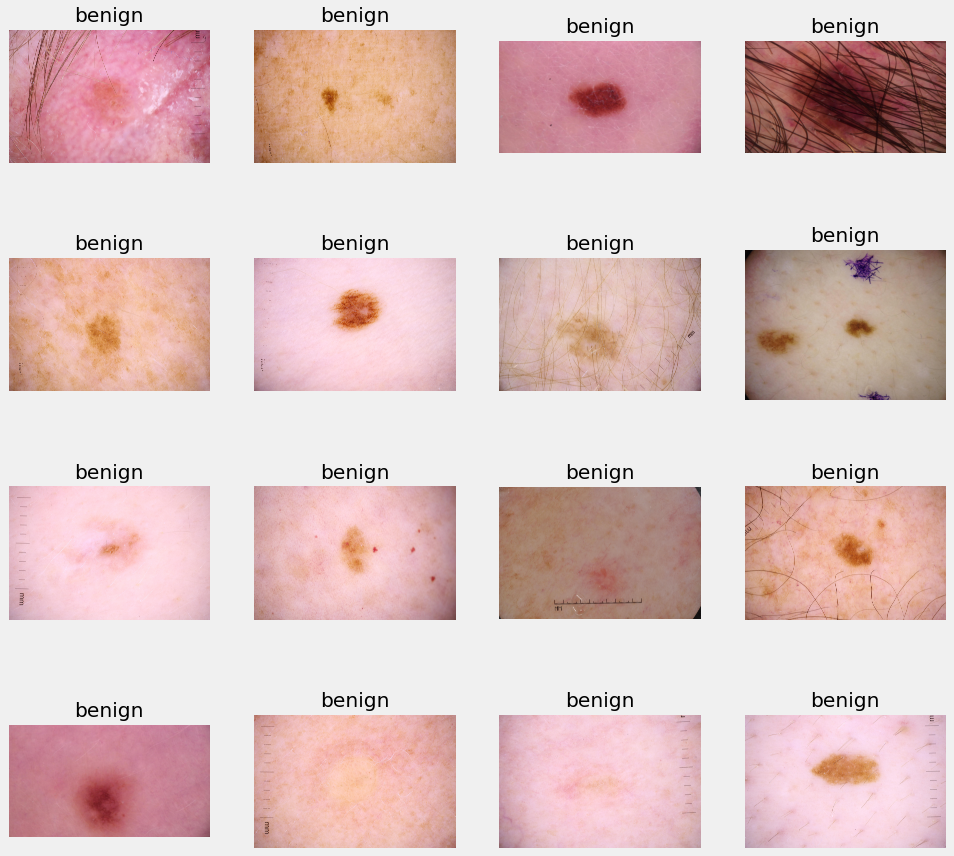

In [11]:
#Plotting benign images
w = 10
h = 10
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 4

#ax enables access to manipulate each of subplots
ax = []

for i in range(columns*rows):
    img = plt.imread('/kaggle/input/siim-isic-melanoma-classification/jpeg/train/'+train['image_name'][i]+'.jpg')
    #creating a subplot and appending it to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
    #hiding grid lines
    ax[-1].grid(False)

    #hiding axes ticks
    ax[-1].set_xticks([])
    ax[-1].set_yticks([])
    ax[-1].set_title(train['benign_malignant'][i])
    plt.imshow(img)

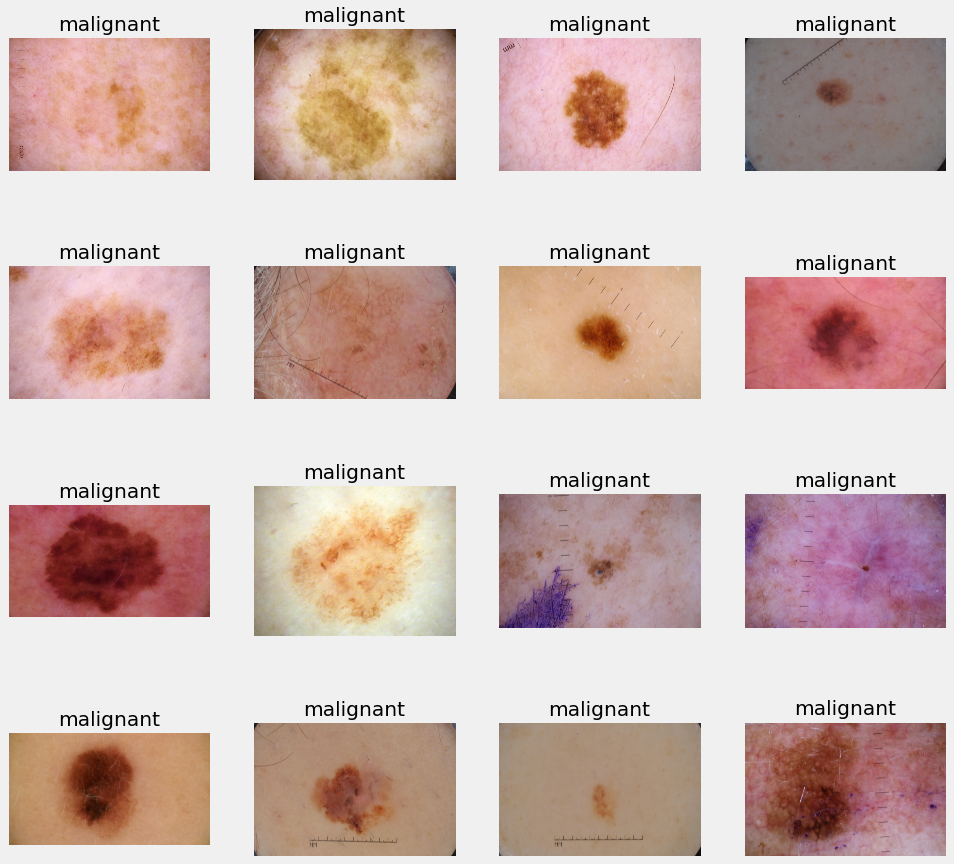

In [12]:
#Plotting malignant images
w = 10
h = 10
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 4

ax = []

for i in range(columns*rows):
    img = plt.imread('/kaggle/input/siim-isic-melanoma-classification/jpeg/train/'+train.loc[train['target'] == 1]['image_name'].values[i]+'.jpg')
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].grid(False)
    ax[-1].set_xticks([])
    ax[-1].set_yticks([])
    ax[-1].set_title(train.loc[train['target'] == 1]['benign_malignant'].values[i])
    plt.imshow(img)

In [13]:
#Checking for missing values in the train set
total = train.isnull().sum().sort_values(ascending=False)
percent = train.isnull().mean().sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

Total   Percent
anatom_site_general_challenge    527  0.015909
age_approx                        68  0.002053
sex                               65  0.001962
target                             0  0.000000
benign_malignant                   0  0.000000

In [14]:
#Checking for missing values in the test set
total = test.isnull().sum().sort_values(ascending=False)
percent = test.isnull().mean().sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

Total   Percent
anatom_site_general_challenge    351  0.031961
age_approx                         0  0.000000
sex                                0  0.000000
patient_id                         0  0.000000
image_name                         0  0.000000

# Preparing Data for the Model

In [15]:
#Imputing missing values
train['sex'] = train['sex'].fillna('male')
train['age_approx'] = train['age_approx'].fillna(train['age_approx'].mean())
train['anatom_site_general_challenge'] = train['anatom_site_general_challenge'].fillna('head/neck')
test['anatom_site_general_challenge'] = test['anatom_site_general_challenge'].fillna('head/neck')

In [16]:
#Transforming the values into categorical
from sklearn.preprocessing import LabelEncoder
enc1 = LabelEncoder()
enc2 = LabelEncoder()

train['sex'] = enc1.fit_transform(train['sex'])
train['anatom_site_general_challenge'] = enc2.fit_transform(train['anatom_site_general_challenge'])
test['anatom_site_general_challenge'] = enc2.fit_transform(test['anatom_site_general_challenge'])

In [17]:
#Detecting TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [18]:
#For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE

#Accessing the data
GCS_PATH = KaggleDatasets().get_gcs_path('siim-isic-melanoma-classification')

In [19]:
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/tfrecords/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/tfrecords/test*.tfrec')

CLASSES = [0,1]   
IMAGE_SIZE = [1024, 1024]
BATCH_SIZE = 8 * strategy.num_replicas_in_sync

In [20]:
import re
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  #converting image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) #explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), #tf.string means bytestring
       
        "target": tf.io.FixedLenFeature([], tf.int64),  #shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['target'], tf.int32)
    
    return image, label #returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['image_name']
    return image, idnum #returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    #Reading from TFRecords. For optimal performance, reading from multiple files at once and
    #disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False #disabling order, increasing speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) #automatically interleaving reads from multiple files
    dataset = dataset.with_options(ignore_order) #using data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    #returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.1)
    image = tf.image.random_flip_up_down(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   
def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() #the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) #prefetching next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print('Dataset: {} training images and {} unlabeled test images'.format(NUM_TRAINING_IMAGES,NUM_TEST_IMAGES))

Dataset: 33126 training images and 10982 unlabeled test images


Here we're performing **Data Augmentation** to solve the problem of data imbalance, which we detected in our analysis. **Data Augmentation** creates modified versions of the images in our dataset. It allows us to add images to the dataset without us having to collect new ones by taking a particular image and performing various sorts of image enhancements such as rotate, mirror and flip

# Model

We are going to use **Convolutional Neural Network (CNN)**. **CNN** is a class of Deep Learning, mostly applied to analyze visual images. There is a variety of convolutional neural networks and all have their own advantage

<img src="https://i.imgur.com/cakzqc6r.jpg" width="800">

In this kernel we will implement **EfficientNetB7** - a framework that was released by Google AI in 2019, which achieves much better accuracy and efficiency as compared to the previous Convolutional Neural Networks

In [21]:
#Defining the parameters
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
EPOCHS = 4

In [22]:
def build_lrfn(lr_start=0.00001, lr_max=0.0001, 
               lr_min=0.000001, lr_rampup_epochs=20, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    
    return lrfn

In [23]:
import efficientnet.tfkeras as efn
#Defining the model
with strategy.scope():
    efficientnetb7_model = tf.keras.Sequential([
        efn.EfficientNetB7(
            input_shape=(*IMAGE_SIZE, 3),
            #weights='imagenet',
            weights='imagenet',
            include_top=False
        ),
        L.GlobalAveragePooling2D(),
        L.Dense(1024, activation = 'relu'), 
        L.Dropout(0.3), 
        L.Dense(512, activation= 'relu'), 
        L.Dropout(0.2), 
        L.Dense(256, activation='relu'), 
        L.Dropout(0.2), 
        L.Dense(128, activation='relu'), 
        L.Dropout(0.1), 
        L.Dense(1, activation='sigmoid')
    ])

258441216/258434480 [==============================] - 25s 0us/step


In [24]:
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=.25):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
	return focal_loss_fixed

In [25]:
#Compiling the model
efficientnetb7_model.compile(
    optimizer='Adam',
    loss = focal_loss(gamma=2., alpha=.25),
    #loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.1),
    metrics=['binary_crossentropy', 'accuracy']
)
efficientnetb7_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 32, 32, 2560)      64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2622464   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               1

In [26]:
lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

In [27]:
#model.load_weights('../input/melanoma/model_weights.h5')

In [28]:
#Training the model
history = efficientnetb7_model.fit(
    get_training_dataset(), 
    epochs=EPOCHS, 
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr_schedule],
    class_weight = {0:0.50899675,1: 28.28782609}
)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/4
517/517 [==============================] - 982s 2s/step - accuracy: 0.9445 - binary_crossentropy: 0.3585 - loss: 0.0460 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 4.95e-05.
Epoch 2/4
517/517 [==============================] - 983s 2s/step - accuracy: 0.9827 - binary_crossentropy: 0.2210 - loss: 0.0230 - lr: 4.9500e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 8.9e-05.
Epoch 3/4
517/517 [==============================] - 983s 2s/step - accuracy: 0.9823 - binary_crossentropy: 0.1998 - loss: 0.0226 - lr: 8.9000e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0001285.
Epoch 4/4
517/517 [==============================] - 983s 2s/step - accuracy: 0.9819 - binary_crossentropy: 0.1938 - loss: 0.0217 - lr: 1.2850e-04


In [29]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

accuracy  binary_crossentropy      loss        lr  epoch
0  0.944451             0.358538  0.046046  0.000010      0
1  0.982743             0.220959  0.023023  0.000049      1
2  0.982320             0.199786  0.022591  0.000089      2
3  0.981897             0.193843  0.021670  0.000129      3

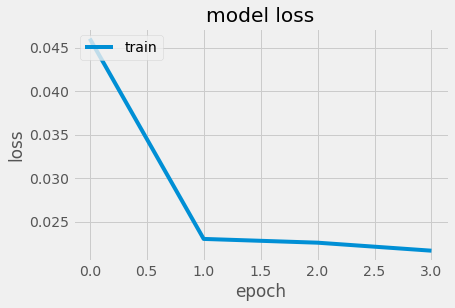

In [30]:
#Visualizing model's loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

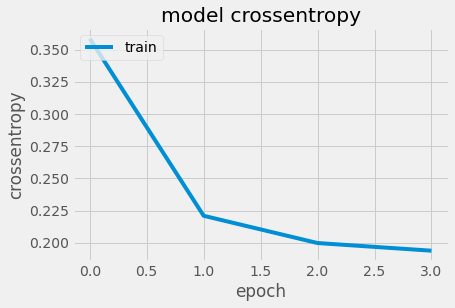

In [31]:
#Visualizing model's crossentropy
plt.plot(history.history['binary_crossentropy'])
plt.title('model crossentropy')
plt.ylabel('crossentropy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [32]:
efficientnetb7_model.save('complete_data_efficient_model.h5')

In [33]:
efficientnetb7_model.save_weights('complete_data_efficient_weights.h5')

# Predictions

In [34]:
test_ds = get_test_dataset(ordered=True)
test_images_ds = test_ds.map(lambda image, idnum: image)

In [35]:
probabilities = efficientnetb7_model.predict(test_images_ds)

In [36]:
print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') #all in one batch

Generating submission.csv file...


In [37]:
pred_df = pd.DataFrame({'image_name': test_ids, 'target': np.concatenate(probabilities)})
pred_df.head()

image_name    target
0  ISIC_6381819  0.340805
1  ISIC_5583376  0.199905
2  ISIC_6408546  0.056655
3  ISIC_6932354  0.386158
4  ISIC_8191278  0.173758

In [38]:
sub = pd.read_csv("/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv")
sub

image_name  target
0      ISIC_0052060       0
1      ISIC_0052349       0
2      ISIC_0058510       0
3      ISIC_0073313       0
4      ISIC_0073502       0
...             ...     ...
10977  ISIC_9992485       0
10978  ISIC_9996992       0
10979  ISIC_9997917       0
10980  ISIC_9998234       0
10981  ISIC_9999302       0

[10982 rows x 2 columns]

In [39]:
del sub['target']
sub = sub.merge(pred_df, on='image_name')
#sub.to_csv('submission_label_smoothing.csv', index=False)
sub.to_csv('complete_data.csv', index=False)
sub.head()

image_name    target
0  ISIC_0052060  0.094973
1  ISIC_0052349  0.045413
2  ISIC_0058510  0.046530
3  ISIC_0073313  0.050769
4  ISIC_0073502  0.264514

**References:** [https://www.kaggle.com/shubhamai/melanoma-classification](http://) 